In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision as tv
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import glob
from PIL import Image
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [2]:
class STLDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""

    def __init__(self, df, transform=None):
        self.file_paths = df.img.values
        self.labels = df.y.values
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        image = Image.open(file_path)

        if self.transform:
            image = self.transform(image)

        return image, label, file_path

In [55]:
root_path = '.\\input\\train\\'

df_train = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_train['img'] = [f for f in files]
df_train['y'] = [int(f.split('\\')[-2]) - 1 for f in df_train.img]

In [56]:
root_path = '.\\input\\test\\'

df_test = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_test['img'] = [f for f in files]
df_test['y'] = [int(f.split('\\')[-2]) - 1 for f in df_test.img]



In [57]:
train_transform = transforms.Compose([
    # transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.45),
    transforms.RandomVerticalFlip(p=0.45),
    # transforms.RandomGrayscale(p=0.15),
    # transforms.ColorJitter(brightness=0.8, contrast=1.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

test_transform = transforms.Compose([
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [58]:
num_workers = 0
batch_size = 32

train_dataset = STLDataset(df_train, transform=train_transform)
valid_dataset = STLDataset(df_test, transform=test_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [123]:
train_dataset = STLDataset(df_train2, transform=train_transform)


trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

        cat        deer         cat       truck


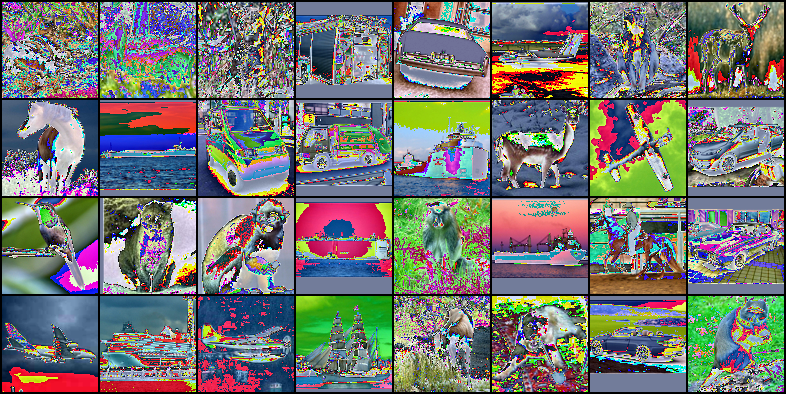

In [44]:
dataiter = iter(trainloader)
images, labels, _ = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'% classes[labels[j]-1] for j in range(4)))
show(tv.utils.make_grid((images+1)/2))

In [124]:
model = tv.models.vgg16_bn(pretrained='ImageNet')
model.classifier = nn.Sequential(
    nn.Linear(in_features=4608, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=10, bias=True),
  )
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [60]:
def train(net, epoch):

    net.train()
    
    losses = 0
    for batch_index, (images, labels, _) in enumerate(trainloader):

        images = Variable(images)
        labels = Variable(labels)

        labels = labels.cuda()
        images = images.cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        trained_samples = batch_index * batch_size + len(images)
        losses += loss.item()
    
    print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
                losses / trained_samples,
                optimizer.param_groups[0]['lr'],
                epoch=epoch,
                trained_samples=trained_samples,
                total_samples=len(trainloader.dataset)
            ))

def valid(net, epoch):
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0

    for (images, labels, _) in validloader:
        images = Variable(images)
        labels = Variable(labels)

        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum()

    print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
        test_loss / len(validloader.dataset),
        correct.float() / len(validloader.dataset)
    ))
    print()

    #add informations to tensorboard
    #writer.add_scalar('Test/Average loss', test_loss / len(cifar100_test_loader.dataset), epoch)
    #writer.add_scalar('Test/Accuracy', correct.float() / len(cifar100_test_loader.dataset), epoch)

    return correct.float() / len(validloader.dataset)


In [125]:
lr = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

EPOCH = 100 #约在45-60之间收敛完毕
net_type = 'vgg16_bn'
best_acc = 0.0
for epoch in range(1, EPOCH):

    train(model, epoch)
    acc = valid(model, epoch)

    #start to save best performance model after learning rate decay to 0.01 
    if best_acc < acc:
        best_acc = acc
        patient = 0
        torch.save(model.state_dict(), './models/{}_{}_{}.pth'.format(net_type, epoch, best_acc))


Training Epoch: 1 [8313/8313]	Loss: 0.0378	LR: 0.001000
Test set: Average loss: 0.0129, Accuracy: 0.8838

Training Epoch: 2 [8313/8313]	Loss: 0.0103	LR: 0.001000
Test set: Average loss: 0.0093, Accuracy: 0.9061

Training Epoch: 3 [8313/8313]	Loss: 0.0066	LR: 0.001000
Test set: Average loss: 0.0081, Accuracy: 0.9123

Training Epoch: 4 [8313/8313]	Loss: 0.0052	LR: 0.001000
Test set: Average loss: 0.0074, Accuracy: 0.9199

Training Epoch: 5 [8313/8313]	Loss: 0.0039	LR: 0.001000
Test set: Average loss: 0.0075, Accuracy: 0.9204

Training Epoch: 6 [8313/8313]	Loss: 0.0032	LR: 0.001000
Test set: Average loss: 0.0072, Accuracy: 0.9224

Training Epoch: 7 [8313/8313]	Loss: 0.0023	LR: 0.001000
Test set: Average loss: 0.0071, Accuracy: 0.9260

Training Epoch: 8 [8313/8313]	Loss: 0.0021	LR: 0.001000
Test set: Average loss: 0.0071, Accuracy: 0.9253

Training Epoch: 9 [8313/8313]	Loss: 0.0017	LR: 0.001000
Test set: Average loss: 0.0072, Accuracy: 0.9283

Training Epoch: 10 [8313/8313]	Loss: 0.0017	LR

Test set: Average loss: 0.0085, Accuracy: 0.9334

Training Epoch: 78 [8313/8313]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0087, Accuracy: 0.9305

Training Epoch: 79 [8313/8313]	Loss: 0.0001	LR: 0.001000
Test set: Average loss: 0.0086, Accuracy: 0.9310

Training Epoch: 80 [8313/8313]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0091, Accuracy: 0.9291

Training Epoch: 81 [8313/8313]	Loss: 0.0001	LR: 0.001000
Test set: Average loss: 0.0087, Accuracy: 0.9323

Training Epoch: 82 [8313/8313]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0090, Accuracy: 0.9284

Training Epoch: 83 [8313/8313]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0087, Accuracy: 0.9314

Training Epoch: 84 [8313/8313]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0085, Accuracy: 0.9333

Training Epoch: 85 [8313/8313]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0087, Accuracy: 0.9325

Training Epoch: 86 [8313/8313]	Loss: 0.0000	LR: 0.001000
Test set: Average loss: 0.0084, Accur

In [62]:
classes = ('airplane', 'bird', 'car', 'cat','deer', 
           'dog', 'horse', 'monkey', 'ship', 'truck')

In [63]:
num_workers = 0
batch_size = 32

root_path = '.\\input\\unlabeled\\'

df_unlabeled = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_unlabeled['img'] = [f for f in files]
df_unlabeled['y'] = 0

unlabeled_dataset = STLDataset(df_unlabeled, transform=test_transform)

unlabeledloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

预测结果:    dog   car airplane truck horse  bird  deer   cat  bird   cat   dog airplane   dog truck horse  bird horse truck  ship truck  ship airplane airplane monkey truck  deer horse  bird monkey   dog airplane truck


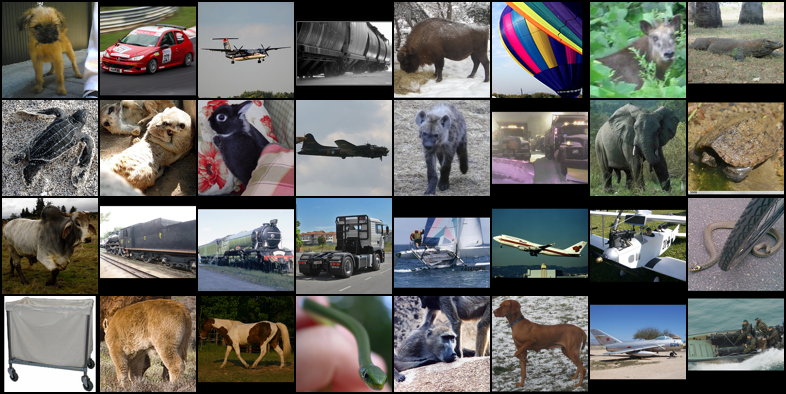

In [65]:
dataiter = iter(unlabeledloader)
images, labels, filenames = dataiter.next() # 返回4张图片及标签

#print(' '.join('%11s'% classes[labels[j]-1] for j in range(32)))


imgs = None
for f in filenames:
    img = np.array(Image.open(f))
    if(imgs is None):
        imgs = np.concatenate([img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])
    else:
        imgs = np.concatenate([imgs, img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])

# 计算图片在每个类别上的分数
outputs = model(images.cuda())
# 得分最高的那个类
_, predicted = torch.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(32)))

show(tv.utils.make_grid((torch.tensor(imgs))))

In [142]:
preds = outputs.softmax(dim=1)
preds

tensor([[9.9961e-01, 2.9677e-05, 1.1552e-06, 2.5966e-04, 1.3327e-05, 3.5652e-05,
         4.0282e-05, 6.0261e-07, 2.1111e-07, 9.0261e-06],
        [7.0001e-02, 4.2006e-05, 2.6043e-05, 3.2616e-05, 6.1070e-05, 1.2866e-05,
         3.8565e-05, 3.4814e-05, 4.0013e-05, 9.2971e-01],
        [2.4962e-01, 9.3613e-02, 3.9945e-03, 1.7398e-03, 6.2572e-04, 8.8721e-02,
         5.0688e-03, 5.4878e-01, 1.6836e-03, 6.1516e-03],
        [3.7656e-02, 8.0500e-04, 9.0468e-05, 1.9200e-04, 1.4544e-04, 7.2605e-05,
         1.6591e-04, 1.1931e-04, 1.0486e-04, 9.6065e-01],
        [6.2795e-01, 3.8272e-03, 1.9017e-03, 3.5400e-01, 4.9115e-05, 3.2448e-04,
         8.7398e-03, 2.6762e-03, 2.6553e-04, 2.6157e-04],
        [9.4944e-02, 9.9071e-04, 3.0320e-04, 2.8449e-04, 2.0660e-04, 1.9637e-04,
         2.3195e-04, 2.2622e-04, 1.6846e-04, 9.0245e-01],
        [1.4184e-01, 8.5785e-01, 5.8323e-06, 8.7596e-05, 6.1666e-07, 4.6969e-06,
         2.1320e-06, 7.2199e-05, 8.1724e-06, 1.3165e-04],
        [1.4269e-01, 3.0910

In [66]:
def predict(net, dataloader):
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0
    
    preds = None
    
    filelist = []

    for (images, labels, filenames) in dataloader:
        filelist += filenames
        
        images = Variable(images)
        labels = Variable(labels)

        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        
        p = outputs.softmax(dim=1).cpu().data.numpy()

        if (preds is None):
            preds = np.concatenate([p])
        else:
            preds = np.concatenate([preds, p])
        

    #add informations to tensorboard
    #writer.add_scalar('Test/Average loss', test_loss / len(cifar100_test_loader.dataset), epoch)
    #writer.add_scalar('Test/Accuracy', correct.float() / len(cifar100_test_loader.dataset), epoch)

    return preds, filelist

In [67]:
PATH = './models/vgg16_bn_55_0.9376250505447388.pth' 
# 学习率为0.001， 优化器为SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)， 
model.load_state_dict(torch.load(PATH))
model.cuda().eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [68]:
preds, filelist = predict(model, unlabeledloader)

In [89]:
df_preds = pd.DataFrame(data=preds)

df_preds['img'] = filelist
df_preds['y'] = preds.argmax(axis=1)

In [90]:
# df_preds['y'] -= 2
df_preds['p'] = preds.max(axis=1)


df_preds.head(32)

,0,1,2,3,4,5,6,7,8,9,img,y,p
0,7.154747e-05,1.843717e-02,1.947173e-04,9.762898e-01,2.525965e-03,6.831133e-05,7.279395e-06,4.804923e-04,1.817909e-03,1.067275e-04,.\input\unlabeled\37001.png,3,0.976290
1,2.901721e-05,7.801029e-04,1.555988e-04,4.886881e-01,2.860692e-05,5.089902e-01,3.333130e-05,8.868040e-04,2.417389e-04,1.665394e-04,.\input\unlabeled\82840.png,5,0.508990
2,4.444048e-05,1.948471e-05,1.839523e-06,1.070243e-03,6.037934e-04,9.981009e-01,3.104802e-05,1.275419e-04,3.057736e-07,3.839059e-07,.\input\unlabeled\60419.png,5,0.998101
3,1.085784e-05,4.135281e-06,1.266070e-05,6.350370e-01,1.685511e-04,3.635722e-01,9.321126e-04,5.758700e-05,3.612270e-05,1.687547e-04,.\input\unlabeled\69373.png,3,0.635037
4,5.078416e-01,5.143093e-02,1.382025e-02,2.758769e-01,1.390332e-03,8.996771e-03,9.914445e-04,7.469861e-04,4.939508e-02,8.950975e-02,.\input\unlabeled\63890.png,0,0.507842
5,1.645379e-11,1.340326e-09,1.322630e-09,1.683533e-08,1.755471e-10,1.010986e-09,2.253668e-11,1.000000e+00,5.182219e-11,1.391582e-10,.\input\unlabeled\27134.png,7,1.000000
6,5.368348e-08,3.434562e-09,1.148662e-09,8.963462e-08,4.532633e-10,8.020735e-09,1.509649e-09,2.892675e-10,9.999995e-01,4.050810e-07,.\input\unlabeled\22621.png,8,1.000000
7,4.517581e-05,4.478859e-06,7.736420e-06,1.261605e-05,3.934782e-06,9.132063e-06,3.240375e-05,2.643111e-06,9.986475e-01,1.234408e-03,.\input\unlabeled\7522.png,8,0.998648
8,1.273483e-05,2.014864e-03,8.033243e-06,8.260119e-04,5.015285e-06,9.958125e-01,1.151065e-03,1.081216e-04,4.300494e-05,1.876261e-05,.\input\unlabeled\1755.png,5,0.995812
9,2.371892e-07,2.072000e-05,1.686031e-06,6.649678e-06,2.424335e-06,9.159598e-07,2.232204e-05,9.999411e-01,1.261860e-06,2.626616e-06,.\input\unlabeled\59153.png,7,0.999941


In [120]:
df_temp = df_preds[df_preds.p==1]

In [122]:
df_train2 = pd.concat([df_train, df_temp[['img', 'y']]])
df_train2.shape

(8313, 2)

[0.99996674, 0.99998665, 0.9999869, 0.9999552, 0.9999701, 0.9999733, 1.0, 0.9999037, 0.9999554, 0.99991477, 0.9999273, 0.99997604, 0.99997807, 0.9999366, 0.9999989, 0.9999968, 0.9999919, 0.9999465, 0.9999622, 0.99991405, 0.9999796, 0.9999753, 0.9999318, 0.9999484, 0.9999994, 0.99999344, 0.99999976, 0.9999777, 0.99994624, 0.9999968, 0.9999231, 0.99990225]


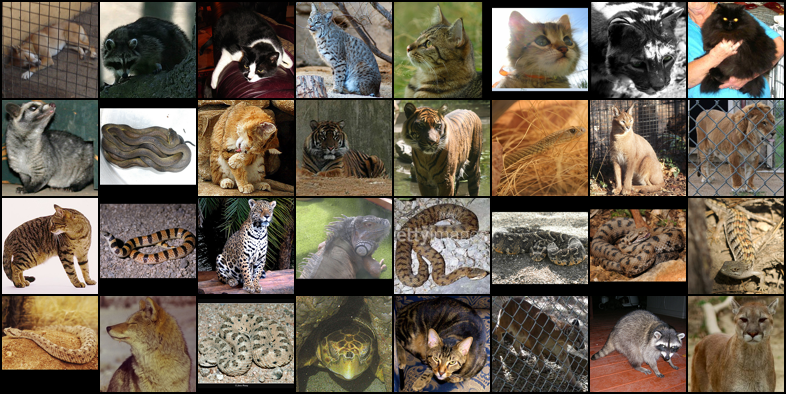

In [117]:
# img = Image.open(df_preds.iloc[0].filelist)

df_temp2 = df_temp[df_temp.y==3]
imgs = None

ylist = []
plist = []
for i in range(32):
    raw = df_temp2.iloc[i]
    # raw = df_preds.iloc[i]
    img = np.array(Image.open(raw.img))
    if(imgs is None):
        imgs = np.concatenate([img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])
    else:
        imgs = np.concatenate([imgs, img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])
        
    ylist.append(classes[9 if raw.y == -1 else raw.y])  
    plist.append(raw.p)

print(plist)
show(tv.utils.make_grid((torch.tensor(imgs))))


In [119]:
for i, g in df_temp.groupby('y'):
    print(classes[i], g.shape)

airplane (351, 13)
bird (382, 13)
car (31, 13)
cat (120, 13)
deer (277, 13)
dog (596, 13)
horse (449, 13)
monkey (277, 13)
ship (358, 13)
truck (472, 13)
